## Search Engine

In [1]:
# Libraries for reading data
import numpy as np
import pandas as pd 
from tqdm import tqdm
import glob
import json
from google.colab import drive
drive.mount('/content/drive')

# Libraries for pre-processing
import re
import nltk
import string
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Libraries for information retrival
# !pip install spacy
import spacy
# Load English tokenizer, tagger, parser and NER
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English
import networkx as nx

# Libraries for word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import datapath

# Libraries for data analysis
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### 1. Reading dataset and pre-processing

#### 1.1 Summary
Our dataset is COVID-19 Open Research Dataset (CORD-19). According to Kaggle, the dataset contains "1,000,000 scholarly articles,  including over 400,000 with full text" and topics are about "COVID-19, SARS-CoV-2, and related coronaviruses" [1]. 

First, we manully download dataset from Kaggle and reading data. For full text, there are two formats: PDF and PMC. In our experiment, we selected PMC as the PDF data has more missing information especially missing some cord_uid. The whole dataset has the size of around 20 Gigabytesis so we need to use a random sample. Our **sample size is 10,000 articles**, which is 1% of orginal data size. Data is the same as search_engine_v1. 

data columns:

*   docid: using cord_uid
*   doi
*   authors
*   title
*   abstract
*   journal
*   body

Then, we pre-process data including **removing stopwords and Lemmalization**(Section 1.3 Data Pre-processing). **Removing stopwords** help to concentrate on important information. **Lemmalization** return root words. **removing stopwords and Lemmalization** will not influence the major semantic of sentences. We would like to keep data in sentence level to analyze semantics, that's why we does not remove puncuation. In order to have better named entity recognition, we keep capitalization as captical words have special meaning and can be used to identify name, organization and place.

Finally, we saved the data into data_v2_clean. 

P.S. Save each version of data into csv format to avoid repeating operation.

#### 1.2 Data Pre-processing

In [2]:
# Overview of sampled data
# data_v1: original data
data_v1 = pd.read_csv("/content/drive/My Drive/NLP/covid_articles_v1.csv", index_col=False)
data_v1.head()

,docid,doi,authors,title,abstract,journal,body
0,ynh8eo6x,10.1007/s11125-021-09564-8,"Amin, Nyna; Mahabeer, Pryah",Curriculum tinkering in situations of crises a...,This article interrogates a curriculum recover...,Prospects (Paris),"In this section, we provide an overview of Sou..."
1,g0bgp3t7,10.3389/fimmu.2021.754642,"Coleman, Celeste; Doyle-Meyers, Lara A.; Russe...",Similarities and Differences in the Acute-Phas...,Understanding SARS-CoV-2 immune pathology is c...,Front Immunol,The rapid emergence and dissemination of sever...
2,x1r99rlm,10.3382/ps/pev336,"Yokhana, J. S.; Parkinson, G.; Frankel, T. L.",Effect of insoluble fiber supplementation appl...,Two experiments were conducted to study effect...,Poult Sci,Growth and development in layer pullets during...
3,m5pwtv7d,10.1007/978-3-030-51761-8_5,"Alonayq, Abdulmohsen",Narrating Arabic Translation Online: Another P...,This chapter takes a socionarrative approach t...,When Translation Goes Digital,The translation sector has seen an increase in...
4,ztzsj45b,10.3390/cells11030575,"Suzuki, Hiroyuki; Kaneko, Mika K.; Kato, Yukinari",Roles of Podoplanin in Malignant Progression o...,Podoplanin (PDPN) is a cell-surface mucin-like...,Cells,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...


In [ ]:
# Step 1: Checking data type
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   docid     10000 non-null  object
 1   doi       9973 non-null   object
 2   authors   9849 non-null   object
 3   title     10000 non-null  object
 4   abstract  8592 non-null   object
 5   journal   9946 non-null   object
 6   body      10000 non-null  object
dtypes: object(7)
memory usage: 547.0+ KB


In [3]:
# Step 2: Handling missing value
def handling_missing_value(data):
    # checking missing value
    print("Missing value in original data data_v1\n", data.isnull().sum())
    # Handling missing value
    data['doi'] = data['doi'].fillna('No_doi')
    data['authors'] = data['authors'].fillna('No_authors')
    data['journal'] = data['journal'].fillna('No_journal')
    data['abstract'] = data['abstract'].fillna('No_abstract')
    # checking missing value after handling missing value
    print("_"*20)
    print("Missing value in new data data_v2\n", data.isnull().sum())
    return data

print("data_v2: handling missing value")
data_v2 = handling_missing_value(data_v1)

data_v2: handling missing value
Missing value in original data data_v1
 docid          0
doi           27
authors      151
title          0
abstract    1408
journal       54
body           0
dtype: int64
____________________
Missing value in new data data_v2
 docid       0
doi         0
authors     0
title       0
abstract    0
journal     0
body        0
dtype: int64


In [ ]:
# Step 3: Data pre-processing
stop_words = stopwords.words('english')
stop_words.extend(["This", "The", "the"])
def pre_process(data):

    # regular expression to match text patterns
    s = " \[(?=.*\d).*?\]" 

    # Removing stopwords + Lemmalization
    # Stop words are common words that are typically removed from text data before analysis.
    # Lemmatization is the process of reducing a word to its base form, known as its lemma.   
    lemmatizer = WordNetLemmatizer()
    result = [" ".join([lemmatizer.lemmatize(word) for word in re.sub(s, "", text).split() if word not in stop_words]) for text in data]

    return result

In [ ]:
# data_v2['clean'] includes data_v2['body'] pre-processing
data_v2['clean'] = pre_process(data_v2['body'])
# Save dataset as csv
data_v2.to_csv("/content/drive/My Drive/NLP/covid_data_v1.csv",index=False)

In [4]:
# data_v2_clean: data_v2 + pre-processing*
data_v2_clean = pd.read_csv("/content/drive/My Drive/NLP/covid_data_v1.csv", index_col=False)
data_v2_clean.head()

,docid,doi,authors,title,abstract,journal,body,clean
0,ynh8eo6x,10.1007/s11125-021-09564-8,"Amin, Nyna; Mahabeer, Pryah",Curriculum tinkering in situations of crises a...,This article interrogates a curriculum recover...,Prospects (Paris),"In this section, we provide an overview of Sou...","In section, provide overview South Africa’s de..."
1,g0bgp3t7,10.3389/fimmu.2021.754642,"Coleman, Celeste; Doyle-Meyers, Lara A.; Russe...",Similarities and Differences in the Acute-Phas...,Understanding SARS-CoV-2 immune pathology is c...,Front Immunol,The rapid emergence and dissemination of sever...,rapid emergence dissemination severe acute res...
2,x1r99rlm,10.3382/ps/pev336,"Yokhana, J. S.; Parkinson, G.; Frankel, T. L.",Effect of insoluble fiber supplementation appl...,Two experiments were conducted to study effect...,Poult Sci,Growth and development in layer pullets during...,Growth development layer pullet rearing early ...
3,m5pwtv7d,10.1007/978-3-030-51761-8_5,"Alonayq, Abdulmohsen",Narrating Arabic Translation Online: Another P...,This chapter takes a socionarrative approach t...,When Translation Goes Digital,The translation sector has seen an increase in...,translation sector seen increase volunteer tra...
4,ztzsj45b,10.3390/cells11030575,"Suzuki, Hiroyuki; Kaneko, Mika K.; Kato, Yukinari",Roles of Podoplanin in Malignant Progression o...,Podoplanin (PDPN) is a cell-surface mucin-like...,Cells,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...


### 2. Named Entity Recognition and Knowledge Base

#### 2.1 Summary
For NER, we use **Spacy** by **get_ner function** to recognize named entitites as it has better performance compared to NLTK. Our NER (called **entities**) is a dictionary using "docid" as keys, while a list of dictionaries (named entities and named entities labels as key) are associated items related to a specail key(Section 2.2 NER).

For Knowledge Base, we create a dictionary called self.kb in Knowledge Base class. The keys are canonical names, such as "COVID-19", and values for each key are {"relation": xx, "objects"(associated name): [xx,xx]}. We would like to use KB "relation" to help text matching in sentence level and find a better answer according to relation in Section 4 Test Matching Utility. Use KB "object" in case that we miss some associated named entities, for example, "covid", "COVD-19". 

It can be more complex such as build a knowledge base by anaylzeing each sentence and create dictionary/DataFrame for each sentence in all sample articles. However, it can be time consuming which is not suitable for this small project. But it may be an experiment in the feature. Also, as we removing stopwords, which will affect us to construct relationship of each sentence.

In our experiment, manualy build knowledge base has correct relationship between subjects and objects compared to auto build knowledge base, in which using tagging to analysis each word in a sentence. (Section 2.3 Knowledge Base)

P.S. Save NER dictionary to json file as it is very large and needs massive computing time. **In order to handle a small knowledge base and entities, we only use the first 30 articles for experiments in the following part**.

#### 2.2 NER

In [ ]:
## This Part of code is from ref [8]
from spacy import displacy
class named_entity_recognition:
    def __init__(self):
        self.NER = {}
    
    def example(self, doc):
        # Process whole document
        text = nlp(doc)
        displacy.render(text, style="ent",jupyter=True)
        return None
    
    def get_ner(self, data):
      """
      The function is about name entity recognition.
      Input:
      data-> whole data includes "docid" and "clean"
      Output: dictionary

      """
      for i in range(data.shape[0]):
          # Get document id
          key = data['docid'][i]
          # Initialize key in self.NER if it doesn't exist
          if key not in self.NER.keys():
              self.NER[key] = []
          # Process whole documents
          text = nlp(str(data['clean'][i]))
          # Find named entities, labels
          for ent in text.ents: 
              # Avoid duplicate named entities
              if [ent.text.strip(), ent.label_] not in self.NER[key]:
                  self.NER[key].append({"text":ent.text.strip(),"label":ent.label_})    
      # Check if all keys in data are present in self.NER.keys()
      for key in data['docid']:
          if key not in self.NER.keys():
              self.NER[key] = []  # Initialize missing key with an empty list
      return self.NER

In [ ]:
## This Part of code is from ref [8]
ner = named_entity_recognition()
# visualization of part of named entities from an article
ner.example(data_v2_clean['clean'][0][:400])

In [ ]:
# ner_dic includes document id and NER
ner_dic = ner.get_ner(data_v2_clean)

In [5]:
#*
def write_json(dictionary, filename):
    # save dic as a string
    string =  json.dumps(dictionary)
    
    # save string to json file
    with open(filename, 'w') as f1:
        f1.write(string)
  
def read_json(filename):
    # read string from json file
    with open(filename, 'r') as f2:
        content = f2.read()

    # get the dictionary from json file
    output = json.loads(content)
    
    return output

In [ ]:
# As ner_dic is very large, we decided to save the ner_dic into json format and store in google drive
write_json(ner_dic, '/content/drive/My Drive/NLP/ner2.json')

In [6]:
# Get ner_dic in json format from google drive and rename as entities*
entities = read_json('/content/drive/My Drive/NLP/ner2.json')

In [ ]:
# The entities dictionary is too big to overview, we just simply print the length of it.
print("The length of entities is: ",len(entities))
print("A example of entities is \n", entities['ynh8eo6x'])

The length of entities is:  9820
A example of entities is 
 [{'text': 'South Africa’s', 'label': 'GPE'}, {'text': '2011', 'label': 'DATE'}, {'text': 'Shrestha', 'label': 'GPE'}, {'text': 'al. 2019', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': 'Taba', 'label': 'GPE'}, {'text': '50 year ago', 'label': 'DATE'}, {'text': '1962', 'label': 'DATE'}, {'text': '33', 'label': 'CARDINAL'}, {'text': 'twenty-first century', 'label': 'DATE'}, {'text': 'World Bank', 'label': 'ORG'}, {'text': 'International Labour Organisation', 'label': 'ORG'}, {'text': 'UNESCO', 'label': 'ORG'}, {'text': 'World Economic Forum', 'label': 'ORG'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': '2017', 'label': 'DATE'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': '55%', 'label': 'PERCENT'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text': '25.2%', 'label': 'PERCENT'}, {'text': '13.8 million', 'label': 'CARDINAL'}, {'text': '30.4 mill

In [ ]:
# Manually handling some specail case
entities['ynh8eo6x'][0]['text'] = 'South Africa'
print("A example of entities is \n", entities['ynh8eo6x'])

A example of entities is 
 [{'text': 'South Africa', 'label': 'GPE'}, {'text': '2011', 'label': 'DATE'}, {'text': 'Shrestha', 'label': 'GPE'}, {'text': 'al. 2019', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': 'Taba', 'label': 'GPE'}, {'text': '50 year ago', 'label': 'DATE'}, {'text': '1962', 'label': 'DATE'}, {'text': '33', 'label': 'CARDINAL'}, {'text': 'twenty-first century', 'label': 'DATE'}, {'text': 'World Bank', 'label': 'ORG'}, {'text': 'International Labour Organisation', 'label': 'ORG'}, {'text': 'UNESCO', 'label': 'ORG'}, {'text': 'World Economic Forum', 'label': 'ORG'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': '2017', 'label': 'DATE'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': '55%', 'label': 'PERCENT'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text': '25.2%', 'label': 'PERCENT'}, {'text': '13.8 million', 'label': 'CARDINAL'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text'

In [7]:
# In order to perform experiment in small dataset*
# only get the named entities in first 100 articles

cnt = 0
entities_100 = {}
for k, v in entities.items():
    entities_100[k] = v
    cnt += 1
    if cnt == 100:
      break

print(entities_100.keys())

dict_keys(['ynh8eo6x', 'g0bgp3t7', 'x1r99rlm', 'm5pwtv7d', 'ztzsj45b', 'whchytrr', 'yi870wr8', 'lswvw426', 'l9vye5ci', '1iyz9nn2', 'hm0ovsq4', 'ltgadsp7', '0n0vbax3', '2sptdcbj', '0o4zxngp', 'c2ibxbgo', '7rrwtmw2', '10409mar', 'okihfpp6', 'xtu9r72l', 'jfca5rv6', '9k1fb5bs', 'qk0cyee2', 'ymebxodh', 'h4hxvov8', 'dtyrjfo5', 'daix3d5e', 'yajnzgd5', 'gcc1qjej', 'r9c4odva', 'njrtn2jg', '3mj2d8l2', 'o5r1rjw8', '68oaxlwj', '0k3ktii9', '71451xmg', 'x8w05pze', '2u1cylk4', 'wzwt67oi', 'urwpow4n', 'pt90g4xq', 'hwgoh2r0', 'b5u5hp2r', 'arlbi4yb', '8il8i5ye', 'kfxpf1ym', 'vw0tj8rl', 'yjay3t38', 'z2fdced4', '4kfyevgg', 'l5zn2cor', 'bno1pv1v', 'f8atqdgw', 'v61jvghw', 'n606m6lp', '36wdv3lp', 'om1airzt', 'a9mio9oe', 'dzhk80lw', 'ffsjv82v', '2u91fn5r', 'ala3zf7w', 'xmk267bo', 'olyq4eii', 'fp5t9w6e', 't6sxpn01', 'y49qm4t8', '7idyw242', 'd8kaivf2', 'bnkg47ta', 'jdghxoq1', 'xeqdknea', 'rqradbd7', 'zc209dfx', 'ygl490pn', '8yvsnjhm', 'hf3wd9el', 'odg5duik', 'a8hvtcqe', 'ak39fnck', 'hg8n4hxv', 'qspkh86p', '3di9

#### 2.3 Knowledge Base

In [8]:
# This part of code is from ref[4] and ref[17]

class KnowledgeBase:
    def __init__(self, data):
        self.data = data
        self.kb= {}

    def manually_build_kb(self, ent_pairs):
        if ent_pairs['canonical'] != self.kb.keys():
            self.kb[ent_pairs['canonical']] = [{"relation":ent_pairs['relation'], "object": ent_pairs['associated']}]
        else:
            self.kb[ent_pairs['canonical']].append({"relation":ent_pairs['relation'], "object": ent_pairs['associated']})

    def df_plot(self):
        """Get DataFrame from kb dictionary"""
        subjects, relations, objects = [],[],[]

        for k in self.kb.keys():
            subjects.append(k)
            for i in range(len(self.kb[k])):
              relations.append(self.kb[k][i]['relation'])
              objects.append(self.kb[k][i]['object'])

        kg_df = pd.DataFrame({'subject':subjects,'relation':relations, 'object': objects})       
        return kg_df

    def knowledge_graph(self):
        """knowledge graph"""
        knowledge_dict = {}
        for name in self.kb.keys():
            for i in range(len(self.kb[name])):
              knowledge_dict[name] = self.kb[name][i]['object']

        # Create a new graph
        G = nx.Graph()

        # Add nodes to the graph
        G.add_nodes_from(knowledge_dict.keys())

        # Add edges to the graph
        for node, neighbors in knowledge_dict.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)

        # Set node positions
        pos = nx.spring_layout(G)

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
        nx.draw_networkx_edges(G, pos, edge_color='grey')
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

        # Show the plot
        plt.axis('off')
        plt.show()


    def search(self, query):
        candidates = []
        for name in self.kb.keys():  
            if query == name:
              for i in self.kb[name]:
                  candidates.extend(i['object']) 
        # if candidates == []:
        #   print("There is no associated name for this canonical name.")
        return candidates


##### 2.3.1 Manually create KB

In [9]:
# build KB using the first 20 articles
KB = KnowledgeBase(data_v2_clean[:30])

# Avoid repeated
KB.kb = {} 

# Manually create dictionary
ent_pairs = {
    1: {'canonical': "COVID-19",  'relation':"is", 'associated':["covid19","covid","SARS-CoV-2", "COVD-19", "coronavirus"]},
    2: {'canonical': "coronavirus",  'relation':"is", 'associated':["covid19","covid","COVID-19", "COVD-19", "SARS-CoV-2"]},
    3: {'canonical': "mask",  'relation':"is", 'associated':["face mask","P2 mask"]},
}

# Add dictionary to kb
for k in ent_pairs.keys():
    KB.manually_build_kb(ent_pairs[k])

# Visulization of kb
# Relationships are described correctly and the objects are expected
kg_df = KB.df_plot()
kg_df.head()

,subject,relation,object
0,COVID-19,is,"[covid19, covid, SARS-CoV-2, COVD-19, coronavi..."
1,coronavirus,is,"[covid19, covid, COVID-19, COVD-19, SARS-CoV-2]"
2,mask,is,"[face mask, P2 mask]"


In [ ]:
# test accuracy of manaully create KB 
KB.search("COVID-19")

['covid19', 'covid', 'SARS-CoV-2', 'COVD-19', 'coronavirus']

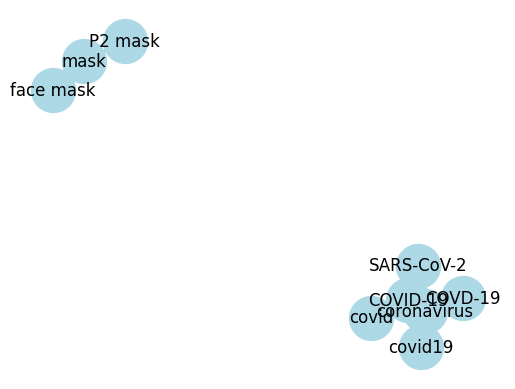

In [ ]:
# KB knowledge_graph
# It is clear to see the associated names for cannonical name
KB.knowledge_graph()

### 3. Indexing method

#### 3.1 summary
Our **InvertedIndex** function use Named Entity as index.

First, it will perfrom a quick search for all the Named Entity based on NER dictionary / entities (in Section 2.2). If we found the query Named Entity in entities, docs_index list will add the related docid according to entities dictionary.

Then, if it cannot be found in entities dictionary, we will perform a greedy search based on the content of all the articles. If we found the query Named Entity exsiting in a article, docs_index list will add the related docid. This is used to handle some special cases, such as "coronavirus".

Finally, we return a docs_index list.

P.S. Code in Section 3.2 Inverted indexing method

#### 3.2 Inverted indexing method

In [10]:
def InvertedIndex(query, ent_dic, data):
    """
    Retrieve a set of documents containing the given query term
    Input:
    query -> one word representing the query term
    ent_dic -> control the range of entities
    data -> control the size of data
    output:
    doc_index -> list of document IDs
    """
    # empty dictionary to store a set of documents
    docs_index = []

    # Retrieve the set of documents containing each query term
    # k: docid; v: name entities and labels
    for k, v in ent_dic.items():
      # if doc_id not in docs_index list
      if k not in docs_index:
          if v != []:
              for i in v[0]['text'].split():
                if query == i:
                  docs_index.append(k)

    # In case cannot find the named_entities, use query to match text
    if docs_index == []:
        for i in range(data.shape[0]):
          if query in data['body'][i]:
              id = data['docid'][i]
              if id not in docs_index:
                docs_index.append(id)
    return docs_index

In [ ]:
# Create an inverted index
# Search for documents containing "COVID-19"
result = InvertedIndex("COVID-19", entities_100, data_v2_clean[:100])
print('Search for documents containing "COVID-19", result:\n', result)

Search for documents containing "COVID-19", result:
 ['qk0cyee2', 'ymebxodh', '4kfyevgg', 'om1airzt', 'ffsjv82v', 'qd30tmuy']


### 4. Text matching utility

#### 4.1 Summary
Our **text_matching_utility class**  retrieves articles based on a question (in Section 4.2). 

Our main function is **text_matching** function (in Section 4.2). Process:

1.   First, we pre-process the question by removing stopwords and lemmization by **query_preprocessing** function.
2.   After we identify named entities in question, we use question named entities by using **get_article_ids** funtion (using **InvertedIndex method** inside function) to find related article ids. Use **KB** to provide a supplement (giving associated name) to named entities in query and get article ids by **get_article_ids** funtion again. 
3. If no article ids, print ""Sorry, no answer for this question." and return. 
4. If we get article ids, we use **get_topk_answers** function to get top k article id, top k answers (first using similarity score to compare question and possible articles, then calculate similarity score between question and each sentence in one article and get best sentence), and cosine similarity score (compare question and best sentence).

NER and KB is useful for my task:

*   Combination of NER and Inverted Index method helps to find article ids efficiently. We only compare question and those articles including named entities rather than all articles. 
*   Using KB as a supplement to find associated named entities for query will help to increase the accuracy of retrieval. Also, 'relation' of named entities will help to find the best answer (this will be explored in the future). 

Pretrained Word Vectors model:

*   At the Begining, we considered Word2Vec and GloVe. After research, we found that GloVe may be better suited for tasks that require a more holistic understanding of language and the relationships between words, which will help us to find a better answer [5][6]. And Word2Vec may be better suited for tasks that require more precise word-level associations. We decide to use GolVe but it's embedding dictionary does not include word such as "COVID-19". (in section 4.5.1)
*   Therefore, we tried tf-idf (in section 4.3) and spaCy pretrain word vector model (in section 4.4). Result discussion in section 4.5.





  

#### 4.2 word embedding class

In [ ]:
# This part of code is (based on) from ref[12], ref[13], and ref[14]

class word_to_vector:
    def __init__(self, prepro_text:list, w2v_path=None):
        self.prepro_text = prepro_text
        self.w2v_path = w2v_path
        self.model = None
        self.keyedvector = None
        if not os.path.isfile(os.path.join(self.w2v_path, 'word2vec_100ep_sg.model')) or not os.path.isfile(os.path.join(self.w2v_path, 'vector_100ep_sg.kv')):
            self.train()
        else:
            self.model = Word2Vec.load(os.path.join(self.w2v_path, 'word2vec_100ep_sg.model'))
            self.keyedvector = KeyedVectors.load(os.path.join(self.w2v_path, 'vector_100ep_sg.kv'))
            print('Config Loaded')

    def train(self, epochs=20):
        tokenized_corpus = [word_tokenize(text) for text in self.prepro_text]
        self.model = Word2Vec(tokenized_corpus, vector_size=100, window=5, min_count=5, sg = 1) ## sg = 1 to skip-gram, change if needed
        # self.model.build_vocab()
        print("start training")
        self.model.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=epochs)
        print("finished training")
        self.model.save(os.path.join(self.w2v_path, 'word2vec_100ep_sg.model'))
        self.model.wv.save(os.path.join(self.w2v_path, 'vector_100ep_sg.kv'))
        self.keyedvector = self.model.wv
    def get_model(self):
        return self.model
    def get_w2v(self):
        return self.model.wv
    def get_keyedVector(self):
        return self.keyedvector
    def transform(self, sentence_token):
        temp = sentence_token
        res = []
        for word in temp:
            if word in self.get_w2v():
              res.append(self.keyedvector[word])
        if len(res) == 0:
          return np.zeros(self.model.vector_size)
        return np.mean(res, axis=0)

In [ ]:
w2v_path = "/content/drive/My Drive/NLP/"
covid_w2v_model = word_to_vector(prepro_text = data_v2_clean['body'].tolist(), w2v_path=w2v_path)

Config Loaded


In [ ]:
# This part of code is from ref[12] and ref[13]
class google_w2v:
  def __init__(self, w2v_path):
      self.path = w2v_path
      self.model = KeyedVectors.load_word2vec_format(datapath(self.path), binary=True)  # C bin format
      
  def transform(self, sentence_token):
      temp = sentence_token
      res = []
      for word in temp:
          if word in self.model:
            res.append(self.model[word])
      if len(res) == 0:
        return np.zeros(self.model.vector_size)
      return np.mean(res, axis=0)

In [ ]:
pretrain_w2v_path = "/content/drive/My Drive/NLP/GoogleNews-vectors-negative300.bin"
google_w2v_model = google_w2v(pretrain_w2v_path)

#### 4.3 Text matching utility class

In [11]:
class text_matching_utility():
    def __init__(self, entities, dataset, kb):
        self.ner = entities              # named entity recognition result
        self.data = dataset              # dataset
        self.kb = kb                     # Knowledge Base


    def query_preprocessing(self, query):
        # regular expression to match text patterns
        s = " \[(?=.*\d).*?\]" 

        # Removing stopwords + Lemmalization
        # Stop words are common words that are typically removed from text data before analysis.
        # Lemmatization is the process of reducing a word to its base form, known as its lemma. 
        stop_words = stopwords.words('english')
        stop_words.extend(["This", "The", "the"])
        lemmatizer = WordNetLemmatizer()
        result = [lemmatizer.lemmatize(word) for word in re.sub(s, "", query).split() if word not in stop_words]
        return result

    def fast_article_retrieval(self, query):
        """
        Use NER, KB, InvertedIndex method to get article ids
        """
        # create a empty list to store article ids
        article_ids = []

        # Step 1: Use NER to identify named entities in the question
        # 1) get named entities
        query_ents = [ent.text.strip() for ent in nlp(" ".join(query)).ents]

        # Step 2: Use InvertedIndex method and NER to get ariticle IDs
        # 1) if named entities found in the question using NER        
        for i in query_ents:
            article_ids.extend(InvertedIndex(i, self.ner, self.data))

        # Step 3: If NER fails, use KB as supplement to find associated name of name entities in the question
        if article_ids == []:
            for word in query:
                lst = self.kb.search(word)  # use KnowledgeBase function
                for i in lst:
                  article_ids.extend(InvertedIndex(i, self.ner, self.data)) 

        # Step 4: If NER and KB fail, use a trival solution to use every word in query to find article id if NER and KB fail
        if article_ids == []:
          for word in query:
              article_ids.extend(InvertedIndex(word, self.ner, self.data))

        # remove repeated article_ids
        article_ids = list(set(article_ids))
        return article_ids

    def slow_article_retrieval(self, query):
        """
        Use NER, KB, InvertedIndex method to get article ids
        """
        # create a empty list to store article ids
        article_ids = []

        # Step 1: Use NER to identify named entities in the question
        # 1) get named entities
        query_ents = [ent.text.strip() for ent in nlp(" ".join(query)).ents]

        # Step 2: Use InvertedIndex method and NER to get ariticle IDs
        # 1) if named entities found in the question using NER        
        for i in query_ents:
              article_ids.extend(InvertedIndex(i, self.ner, self.data))

        # Step 3: Use KB as supplement to find associated name of name entities in the question
        for word in query:
            lst = self.kb.search(word)  # use KnowledgeBase function
            for i in lst:
              article_ids.extend(InvertedIndex(i, self.ner, self.data))
      
        # Step 4: If NER and KB fail, use a trival solution to use every word in query to find article id if NER and KB fail
        if article_ids == []:
            for word in query:
              article_ids.extend(InvertedIndex(word, self.ner, self.data))

        # remove repeated article_ids
        article_ids = list(set(article_ids))

        return article_ids


    def tf_idf_score(self, query, articles, word_vector):
        """
        Use TfidfVectorizer() to convert the text into a matrix of TF-IDF features.
        Input:
        query -> a list of query words
        articles -> a list of strings
        word_vector -> two word_vectors: one is "normal_tfidf", another is "pattern_tfidf"
        Ouput:
        Return tf-idf similarity score.
        """
        # if method == "normal_tfidf", query does not need to change
        # if method == "pattern_tfidf", query becomes a list of query string
        if word_vector == "pattern_tfidf":
          query = [" ".join(query)]
 
        vectorizer = TfidfVectorizer()
        # convert to word vector
        articles_wv = vectorizer.fit_transform(articles)
        # convert to word vector
        query_wv = vectorizer.transform(query)
        # calculate similarity
        similarities = cosine_similarity(query_wv, articles_wv)[0]
        return similarities

    def w2v_score(self,query, articles, word_vector):
        """
        Use pretrained word2vec to convert text into word vectors.
        One is "covid_w2v", another is "googleNews_w2v".
        Return word2vec similarity score.
        """
        w2v_model = None
        if word_vector == "covid_w2v":
           w2v_model = covid_w2v_model
        elif word_vector == "googleNews_w2v":
           w2v_model = google_w2v_model
        elif word_vector == "glove":
          w2v_model = glove_w2v_model

        # convert to word vector
        query_wv = w2v_model.transform(query)
        # convert to word vector
        articles_token = [word_tokenize(article) for article in articles]
        articles_wv = [w2v_model.transform(article) for article in articles_token]
        # calculate similarity
        similarities = cosine_similarity([query_wv], articles_wv)[0]
        return similarities
    
    def get_best_sentence(self, query, article, article_id, word_vector):
        """
        Get the best sentence in one article for a query. 
        Based on cosine similarity score between query and sentences.
        """
        # convert to text into sentences
        sentences_clean = tokenize.sent_tokenize(article)

        # calculate similarity
        # Step 3: select different method according to word_vector
        # Then, get cosine similarity between question and sentences
        if word_vector == "normal_tfidf":
          similarities = self.tf_idf_score(query, sentences_clean, word_vector)
        elif word_vector == "pattern_tfidf":
           similarities = self.tf_idf_score(query, sentences_clean, word_vector)
        elif word_vector == "covid_w2v":
           similarities = self.w2v_score(query, sentences_clean, word_vector)
        elif word_vector == "googleNews_w2v":
          similarities = self.w2v_score(query, sentences_clean, word_vector)
        elif word_vector == "glove":
          similarities = self.w2v_score(query, sentences_clean, word_vector)

        # get the maximum score index position
        best_idx = np.array(similarities).argmax()
        # get the best score
        best_score = max(similarities)
        # get original data
        for j in range(len(self.data['docid'])):
              if self.data['docid'][j] == article_id:
                  body = self.data['body'][j]
        sentences_body = tokenize.sent_tokenize(body)
        answer = sentences_body[best_idx]
        return answer,best_score
        

    def get_topk_answers(self, query, article_ids, k, word_vector):
        """
        Calculate similarity score of matching with the question.
        Get the answer from articles.
        Return top k result based on similarity score
        """
        # Step 1: creat a  empty DataFrame  
        answer_score_df = pd.DataFrame()
        # store article ids
        answer_score_df['Docid'] = article_ids       

        # Step 2: get articles based on ids
        articles = []
        body = []
        answers = []
        for i in article_ids:
            for j in range(len(self.data['docid'])):
              if self.data['docid'][j] == i:
                articles.append(self.data['clean'][j])
                body.append(self.data['body'][j])
        answer_score_df['Articles'] = articles
        answer_score_df['Article_body'] = body
        # answer_score_df['Answer'] = answers

        # Step 3: select different method according to word_vector
        # Then, get cosine similarity between question and articles
        similarities = None
        if word_vector == "normal_tfidf":
          similarities = self.tf_idf_score(query, articles, word_vector)
        elif word_vector == "pattern_tfidf":
           similarities = self.tf_idf_score(query, articles, word_vector)
        elif word_vector == "covid_w2v":
           similarities = self.w2v_score(query, articles, word_vector)
        elif word_vector == "googleNews_w2v":
          similarities = self.w2v_score(query, articles, word_vector)
        elif word_vector == "glove":
          similarities = self.w2v_score(query, articles, word_vector)

        # store similarity socre
        answer_score_df['Article_Score'] = similarities

        # Step 4: sort the articles by their similarity scores and get the top results
        # This part of code is from ref [7]
        answer_score_df2 = answer_score_df.sort_values(by='Article_Score', ascending=False)[:k]

        # Step 5: select the best answer sentence in the top k articles
        answer_list = []
        scores = []
        cnt = 0
        for index, row in answer_score_df2.iterrows():  
            article = row['Articles']
            article_id = row['Docid']
            answer, best_score = self.get_best_sentence(query, article, article_id, word_vector)
            answer_list.append(answer)
            scores.append(best_score)
            cnt += 1
            if cnt == k:
              break
        answer_score_df2['Answer'] = answer_list
        answer_score_df2['Score'] = scores

        # Step 6: sort the best answer according to sentence score
        answer_score_final = answer_score_df2.sort_values(by='Score', ascending=False)[:k]

        return answer_score_final
    

    def text_matching(self, question, k, word_vector,speed="fast"):
        """
        A function for text matching.
        Input:
        question ->  a string of one question
        k -> number of top results, default is 3
        word_vector -> word embedding method, default is "normal_tfidf"
        """

        # Step 1: Question pre-processing
        query = self.query_preprocessing(question)

        # Step 2: Use NER, KB, InvertedIndex method to find article ids
        article_ids = []
        if speed == "fast":
            article_ids = self.fast_article_retrieval(query)
        elif speed == "slow":
            article_ids = self.slow_article_retrieval(query)

        # Step 3: Check article_ids
        # If article_ids is empty, finish the function 
        if article_ids == []:
           print("Sorry, no answer for this question.")
           return None

        # Else: Article_ids is not empty, go through step 4
        # Step 4: Get top k articles answer and score   
        top_results = self.get_topk_answers(query, article_ids, k , word_vector)
        
        return top_results


    def display_results(self, top_results, ): 
        """
        Funtion to display results only when results is not None.
        """
        if top_results is not None:  
            print("_"*50+"\n")
            for index, row in top_results.iterrows():
                print("[Article id]:", row['Docid'])  
                print("[Answer]:\n", row['Answer'])
                print("[Score]:", row['Score'],"\n")
            
        return None

#### 4.4 Word Embedding Results

##### 4.4.1 Using tf-idf word vector for text matching

In [ ]:
# call the class
matching = text_matching_utility(entities_100, data_v2_clean[:100], KB)

In [ ]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=5, word_vector="normal_tfidf")
print("Question: ",question)
matching.display_results(result)

Name ents : []
Question:  how to use face mask
__________________________________________________

[Article id]: fp5t9w6e
[Answer]:
 According to US Centers for Disease Control guidelines for use of PPE in US hospitals [11], both N-95 filtering facemask respirators and powered air-purifying respirators should be accompanied by the use of a full-face shield, helmet, or headpiece.
[Score]: 0.32567822293142595 

[Article id]: hm0ovsq4
[Answer]:
 In 2019, SARS-CoV-2, a highly contagious and novel coronavirus was identified where each infected case infected an average of three other people.1
,
2 As of September 26, 2021, 5,519,728 patients with COVID-19 have been identified in Iran, of which 119,082 deaths have been attributed to the virus.
[Score]: 0.0 



In [ ]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=5,word_vector="normal_tfidf")
print("Question: ",question)
matching.display_results(result)                  

Name ents : []
Question:  what is COVID-19
__________________________________________________

[Article id]: 3mj2d8l2
[Answer]:
 Patients suspected of COVID-19 are placed into COVID-19 cohort areas, exposing them to COVID-19 when they may actually be negative for the disease.
[Score]: 0.5669232216563211 

[Article id]: x8w05pze
[Answer]:
 Almost 30% of patients with confirmed COVID-19 were found to have evidence of myocardial injury and COVID-19 related cardiomyopathy [4, 5].
[Score]: 0.44659534259064365 

[Article id]: 10409mar
[Answer]:
 The effect of immunosuppression on COVID-19 progression would be dependent on the severity of COVID-19 disease and the phase of graft rejection.
[Score]: 0.41788885917814034 

[Article id]: ala3zf7w
[Answer]:
 During the first wave of COVID-19, there were no effective antiviral drugs or vaccines against COVID-19 [21,22].
[Score]: 0.40319129231479467 

[Article id]: hg8n4hxv
[Answer]:
 In December 2019, an outbreak of a new coronavirus infection by SA

In [ ]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=5,word_vector="normal_tfidf")
print("Question: ",question)
matching.display_results(result)    

Name ents : []
Question:  What are the names of coronavirus variants
__________________________________________________

[Article id]: 0n0vbax3
[Answer]:
 Vaccine related thrombo-embolic (TE) complications, though rare, have been reported with COVID-19 vaccines, mainly from Europe and North America.
[Score]: 0.599550586746604 

[Article id]: ffsjv82v
[Answer]:
 Therefore, it could be concluded that similar to LA, calcitriol can fulfill two requirements in order to change Apo form to Locked S form.
[Score]: 0.2415348596473843 

[Article id]: om1airzt
[Answer]:
 The COVID-19 pandemic is in transition.
[Score]: 0.0 

[Article id]: r9c4odva
[Answer]:
 Although initially associated with severe acute respiratory syndrome, the disease spectrum associated with severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has been recognized to exhibit extrapulmonary manifestations.
[Score]: 0.0 

[Article id]: xeqdknea
[Answer]:
 Biologically plausible routes of perinatal SARS-CoV-2 transmissio

##### 4.4.2 Using pattern-tf-idf word vector for text matching

In [ ]:
# call the class
matching = text_matching_utility(entities_100, data_v2_clean[:100], KB)

In [ ]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=5, word_vector="pattern_tfidf")
print("Question: ",question)
matching.display_results(result)

Name ents : []
Question:  how to use face mask
__________________________________________________

[Article id]: hm0ovsq4
[Answer]:
 Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited.
[Score]: 0.3293123252322099 

[Article id]: fp5t9w6e
[Answer]:
 According to US Centers for Disease Control guidelines for use of PPE in US hospitals [11], both N-95 filtering facemask respirators and powered air-purifying respirators should be accompanied by the use of a full-face shield, helmet, or headpiece.
[Score]: 0.27208656020503585 



In [ ]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=5,word_vector="pattern_tfidf")
print("Question: ",question)
matching.display_results(result)             

Name ents : []
Question:  what is COVID-19
__________________________________________________

[Article id]: 3mj2d8l2
[Answer]:
 Patients suspected of COVID-19 are placed into COVID-19 cohort areas, exposing them to COVID-19 when they may actually be negative for the disease.
[Score]: 0.5669232216563211 

[Article id]: x8w05pze
[Answer]:
 Almost 30% of patients with confirmed COVID-19 were found to have evidence of myocardial injury and COVID-19 related cardiomyopathy [4, 5].
[Score]: 0.44659534259064365 

[Article id]: 10409mar
[Answer]:
 The effect of immunosuppression on COVID-19 progression would be dependent on the severity of COVID-19 disease and the phase of graft rejection.
[Score]: 0.41788885917814034 

[Article id]: ala3zf7w
[Answer]:
 During the first wave of COVID-19, there were no effective antiviral drugs or vaccines against COVID-19 [21,22].
[Score]: 0.40319129231479467 

[Article id]: hg8n4hxv
[Answer]:
 In December 2019, an outbreak of a new coronavirus infection by SA

In [ ]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=5,word_vector="pattern_tfidf")
print("Question: ",question)
matching.display_results(result)   

Name ents : []
Question:  What are the names of coronavirus variants
__________________________________________________

[Article id]: 0n0vbax3
[Answer]:
 Vaccine related thrombo-embolic (TE) complications, though rare, have been reported with COVID-19 vaccines, mainly from Europe and North America.
[Score]: 0.599550586746604 

[Article id]: n606m6lp
[Answer]:
 The patient had cancer and previously recovered from coronavirus disease-2019 (COVID-19).
[Score]: 0.3032645902437283 

[Article id]: ffsjv82v
[Answer]:
 Therefore, it could be concluded that similar to LA, calcitriol can fulfill two requirements in order to change Apo form to Locked S form.
[Score]: 0.21331865180068635 

[Article id]: t8j105p1
[Answer]:
 This could be most valuable when evaluating the pathology of SARS-CoV-2 variants or when performing combination studies of multiple neutralizing mAbs.
[Score]: 0.20893336388851827 

[Article id]: z2fdced4
[Answer]:
 There are 16 main molecules designated cucurbitacin A to T, an

##### 4.4.3 Using covid-Word2Vec pretrained word vector for text matching

In [ ]:
# call the class
matching = text_matching_utility(entities_100, data_v2_clean[:100], KB)

In [ ]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=5, word_vector="covid_w2v")
print("Question: ",question)
matching.display_results(result)

Name ents : []
Question:  how to use face mask
__________________________________________________

[Article id]: fp5t9w6e
[Answer]:
 According to US Centers for Disease Control guidelines for use of PPE in US hospitals [11], both N-95 filtering facemask respirators and powered air-purifying respirators should be accompanied by the use of a full-face shield, helmet, or headpiece.
[Score]: 0.8327094316482544 

[Article id]: hm0ovsq4
[Answer]:
 Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited.
[Score]: 0.6578748226165771 



In [ ]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=5,word_vector="covid_w2v")
print("Question: ",question)
matching.display_results(result)             

Name ents : []
Question:  what is COVID-19
__________________________________________________

[Article id]: n606m6lp
[Answer]:
 The patient had cancer and previously recovered from coronavirus disease-2019 (COVID-19).
[Score]: 0.7271546125411987 

[Article id]: ala3zf7w
[Answer]:
 During the first wave of COVID-19, there were no effective antiviral drugs or vaccines against COVID-19 [21,22].
[Score]: 0.7179258465766907 

[Article id]: 10409mar
[Answer]:
 The COVID-19 pandemic has spread to Japan and become a health emergency of national concern.
[Score]: 0.7112464308738708 

[Article id]: hg8n4hxv
[Answer]:
 In December 2019, an outbreak of a new coronavirus infection by SARS-COV-2 in China had quickly become a global health emergency, causing coronavirus disease-19 (COVID-19).1 The current treatment of COVID-19 is mainly supportive, and no specific antiviral therapy is available.2 Patients under immunosuppressive treatment are easy prey for COVID-19.3 The Coronaviridae family is a si

In [ ]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=5,word_vector="covid_w2v")
print("Question: ",question)
matching.display_results(result)   

Name ents : []
Question:  What are the names of coronavirus variants
__________________________________________________

[Article id]: z2fdced4
[Answer]:
 A similar strategy could be employed to curb the surging production of cytokines in SARS-CoV2 infection, where cucurbitacins could be a critical source of future anti-inflammatory drugs for severe viral infections.
[Score]: 0.7640966176986694 

[Article id]: ala3zf7w
[Answer]:
 The etiological agent of this pandemic is a positive-sense single-stranded RNA virus designated as severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), while the disease has been named as coronavirus disease of 2019 (COVID-19) [1,4].
[Score]: 0.7494943141937256 

[Article id]: 0n0vbax3
[Answer]:
 None.
[Score]: 0.72635817527771 

[Article id]: n606m6lp
[Answer]:
 The patient had cancer and previously recovered from coronavirus disease-2019 (COVID-19).
[Score]: 0.7104241847991943 

[Article id]: g0bgp3t7
[Answer]:
 The rapid emergence and dissemination

##### 4.4.4 Using GoogleNew-Word2Vec pretrained word vector for text matching

In [ ]:
# # call the class
matching = text_matching_utility(entities_100, data_v2_clean[:100], KB)

In [ ]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=5, word_vector="googleNews_w2v")
print("Question: ",question)
matching.display_results(result)

Name ents : []
Question:  how to use face mask
__________________________________________________

[Article id]: fp5t9w6e
[Answer]:
 Using the #GetUsPPE hashtag, physicians shared photographs of themselves without proper PPE, video tutorials teaching each other how to create homemade PPE [18], and images of store shelves fully stocked with boxes of N95 masks [19] while hospitals had none [20].
[Score]: 0.48593926429748535 

[Article id]: hm0ovsq4
[Answer]:
 Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited.
[Score]: 0.4526519952525633 



In [ ]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=5,word_vector="googleNews_w2v")
print("Question: ",question)
matching.display_results(result)             

Name ents : []
Question:  what is COVID-19
__________________________________________________

[Article id]: om1airzt
[Answer]:
 The COVID-19 pandemic is in transition.
[Score]: 0.0 

[Article id]: odg5duik
[Answer]:
 Coronavirus disease 2019 (COVID-19), provoked by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), poses a major challenge in intestinal transplantation (ITx) due to the high immunogenicity of the graft, requiring high levels of immunosuppression.
[Score]: 0.0 

[Article id]: xeqdknea
[Answer]:
 Biologically plausible routes of perinatal SARS-CoV-2 transmission include transplacental, contact with infected secretions during delivery and with respiratory droplets after delivery, and breast milk.
[Score]: 0.0 

[Article id]: whchytrr
[Answer]:
 Reactive unilateral lymphadenopathy, along with associated 2-deoxy-2-[18F]fluor-D-glucose (FDG) uptake following vaccination against severe acute respiratory syndrome coronavirus type 2 (SARS-CoV2) has been well-documente

In [ ]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=5,word_vector="googleNews_w2v")
print("Question: ",question)
matching.display_results(result)   

Name ents : []
Question:  What are the names of coronavirus variants
__________________________________________________

[Article id]: ffsjv82v
[Answer]:
 The rate of male bias mortality in COVID-19 patients has been documented72.
[Score]: 0.6824206336209659 

[Article id]: olyq4eii
[Answer]:
 Humanity is currently facing a deadly threat, a severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) pandemic, which is due to the novel 2019 coronavirus outbreak, also known as Coronavirus Disease (COVID-19) (1).
[Score]: 0.6666566729545593 

[Article id]: z2fdced4
[Answer]:
 Moreover, the structural proteins of coronaviruses such as spike (S) proteins are known to show considerable variability among coronavirus species, and targeting the spike proteins has been an extremely laborious task.
[Score]: 0.6572620868682861 

[Article id]: g0bgp3t7
[Answer]:
 Subjects infected with Influenza A virus, Respiratory Syncytial Virus (RSV), human Metapneumovirus (hMPV), various flaviruses and corona

#### 4.6 Result Discussion
Here, we discuss about pretrained word vector model selection and testing results.

In this part, we can see that GloVe is not maintained, and it is hard to find words like "COVID-19" and "covid" (see below code). And it takes too much time to train our own corpus. That's why, we tried tf-idf and spaCy pretrained Word Vector model.

Our questions are

1.   how to use face mask
2.   what is COVID-19
3.   What are the names of cornavirus variants

Table: Score comparision

| Question ID |    tf-idf   |     spaCy   |
| ----------- | ----------- | ----------- |
|      1      |    0.329    |   0.618     |
|      2      |    0.462    |   0.602     |
|      3      |    0.60     |   0.626     |

From table, we can see spaCy got higher scores than tf-idf for all three questions when we compare top 1 answer score. However, answer from spaCy is not related to our query. 


For question 1 about face mask, our tf-idf answer is "Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited." (top1 answer) However, spaCy answers " I knew I could help and make a difference but was unable to." Although spaCy had higher score, it's answer is incorrect and irrelevant. At least tf-idf is good at matching the key word "face mask" of our query with text and find a answer related to our query. For the second and last questions, both of them are not answer correctly. In total, tf-idf tried to match text as much as possible.

Therefore, we can conclude that tf-idf has better performance than spaCy. It helps to identify the most important words in a document. It reduces the impact of common words, such as "the", "and", and "a" appear frequently in most documents. By computing the TF-IDF scores for different documents, it is possible to compare them and identify similarities and differences.

spaCy uses pre-trained word embeddings that are trained on large, diverse datasets, which results in high-quality embeddings. But actually, it does not work well in text matching in our experiment. 

A possible reason why TF-IDF may be more effective is that it is based on the frequency of words in a document or corpus, whereas spaCy word embeddings capture more complex semantic relationships between words. After preprocessing query, only some keywords are left and it may hard for Sapcy to work.

### 5. Test utility and test results

#### 5.1 Summary
MRR stands for Mean Reciprocal Rank, and it is a measure used to evaluate the effectiveness of a search engine algorithm. IMRR measures the average rank of the first relevant result in a set of search results, where each rank is weighted by its reciprocal value. 

The formula for MRR is as follows (shown in **gett_mrr_rank** and **calculate_mrr** function):
MRR = (1/N) * sum(1/rank) [3]

Our MRR result is only 0.158, which means that our search engine algorithm is not effective. As MRR takes into account not only whether a result is relevant or not, but also the order in which the results are presented.

A possible reason is it is hard to match the question patten to a best sentence in the article. And it is hard to analyze semantics according to relationship such as "How many", "when", "what" and "which". If we can use update our KB with more "relation", it may imporve MRR result.  

#### 5.2 Test utility class and MRR result

In [ ]:
class test_utility(text_matching_utility):
    def __init__(self, entities, dataset, kb):
      super().__init__(entities, dataset, kb)
    
    # Function to get the reciprocal rank
    def get_mrr_rank(self, answers, correct_answer):
      for i, answer in enumerate(answers):
              if answer is None:
                  answer = ""
              if correct_answer in answer:
                  return 1 / (i + 1), correct_answer
      return 0, None

    # Function to get query answer
    def get_query_answer(self, question, k, word_vector, speed):
        answers = []
        top_results = self.text_matching(question, k, word_vector, speed)
        # print("Question:", question)
        # self.display_results(top_results)
        if top_results is None:
            answers.append("None")
        else:
          for index, row in top_results.iterrows():
              answers.append(row['Answer'])  
              # answers.append(row['Docid'])
        return answers

    # Function to calculate MRR
    def calculate_mrr(self, test_questions, answers):        
        rr_sum = 0
        results_answers = []
        for i in range(1,11):
            # correct_answer = test_questions[i]['article_id']
            correct_answer = test_questions[i]['answer']
            result_mrr = self.get_mrr_rank(answers[i-1], correct_answer)
            # print("Result_mrr", result_mrr)
            rr_sum += result_mrr[0]
            results_answers.append(result_mrr[1])
        
        return rr_sum / len(test_questions), results_answers

    def display(self ,test_questions, k, word_vector,speed):
      answers = []
      for i in range(1,11):
          answers.append(self.get_query_answer(test_questions[i]['query'], k, word_vector,speed))
      mrr_result = self.calculate_mrr(test_questions, answers)
      print("[MRR result]:", mrr_result[0])
      # print("Answers: \n", answers)

In [ ]:
test_questions = {
   1: {"query":"how to use face mask", "answer":"both N-95 filtering facemask respirators and powered air-purifying respirators should be accompanied by the use of a full-face shield, helmet, or headpiece.","article_id":"hm0ovsq4"}, 
   2: {"query":"when did Wuhan reported COVID-19", "answer":"31 December 2019","article_id":data_v2_clean['docid'][7]}, # "article_id":data_v2_clean['docid'][7]
   3: {"query":"In 1936, how many cases André Lemierre published", "answer":"20", "article_id":data_v2_clean['docid'][9]}, # "article_id":data_v2_clean['docid'][9]
   4: {"query":"which city initially reported COVID-19", "answer":"Wuhan","article_id":data_v2_clean['docid'][7]}, # "article_id":data_v2_clean['docid'][7]
   5: {"query":"what Iran ranks in the world in deaths due to COVID-19",  "answer":"eigth", "article_id":data_v2_clean['docid'][10]}, #"article_id":data_v2_clean['docid'][10]
   6: {"query":"Nightingale Hospitals in UK", "answer":"constructed", "article_id":data_v2_clean['docid'][16]}, # "article_id":data_v2_clean['docid'][16]
   7: {"query":"when is the first COVID-19 patient in Japan was diagnosed",  "answer":"January 2020", "article_id":data_v2_clean['docid'][17]}, # "article_id":data_v2_clean['docid'][17],
   8: {"query":"what is Tuberculosis", "answer":"disease", "article_id":data_v2_clean['docid'][19]}, # "article_id":data_v2_clean['docid'][19], 
   9: {"query":"Has COVID-19 pandemic spread to Japan", "answer":"Japan", "article_id":data_v2_clean['docid'][17]}, # "article_id":data_v2_clean['docid'][25]
   10:{"query":"On 11 March 2020, how many countries reported cases of COVID-19", "answer":"114", "article_id":data_v2_clean['docid'][7]}, # "article_id":data_v2_clean['docid'][7]
}

##### version1 and version2 result (compare to correct ids)

In [ ]:
# call the class
test = test_utility(entities_100, data_v2_clean[:100], KB)
# get mrr of version 2
test.display(test_questions,k=5, word_vector="normal_tfidf", speed="fast")
test.display(test_questions,k=5, word_vector="pattern_tfidf", speed="fast")
test.display(test_questions,k=5, word_vector="covid_w2v", speed="fast")
test.display(test_questions,k=5, word_vector="googleNews_w2v", speed="fast")

[MRR result]: 0.5333333333333333
[MRR result]: 0.75
[MRR result]: 0.5499999999999999
[MRR result]: 0.6833333333333333


In [ ]:
# get mrr of version1
test.display(test_questions,k=5, word_vector="normal_tfidf", speed="slow")
test.display(test_questions,k=5, word_vector="pattern_tfidf", speed="slow")
test.display(test_questions,k=5, word_vector="covid_w2v", speed="slow")
test.display(test_questions,k=5, word_vector="googleNews_w2v", speed="slow")

[MRR result]: 0.55
[MRR result]: 0.65
[MRR result]: 0.35
[MRR result]: 0.45


##### version1 and 2 result (compare to correct answers)

In [ ]:
# call the class
test = test_utility(entities_100, data_v2_clean[:100], KB)
# get mrr of version2
test.display(test_questions,k=5, word_vector="normal_tfidf", speed="fast")
test.display(test_questions,k=5, word_vector="pattern_tfidf", speed="fast")
test.display(test_questions,k=5, word_vector="covid_w2v", speed="fast")
test.display(test_questions,k=5, word_vector="googleNews_w2v", speed="fast")

[MRR result]: 0.45
[MRR result]: 0.55
[MRR result]: 0.6333333333333333
[MRR result]: 0.4533333333333333


In [ ]:
# get mrr of version1
test.display(test_questions,k=5, word_vector="normal_tfidf", speed="slow")
test.display(test_questions,k=5, word_vector="pattern_tfidf", speed="slow")
test.display(test_questions,k=5, word_vector="covid_w2v", speed="slow")
test.display(test_questions,k=5, word_vector="googleNews_w2v", speed="slow")

[MRR result]: 0.33333333333333337
[MRR result]: 0.4
[MRR result]: 0.475
[MRR result]: 0.4


#### 5.3 Compare Article Retrieval Methods

In [ ]:
# create related entities dictionaries
# entities_100 = {}
# for cnt, (k, v) in enumerate(entities.items(), 1):
#     entities_100[k] = v
#     if cnt == 100:
#         break
print("Length of entities_100:", len(entities_100.keys()))
entities_1000 = {}
for cnt, (k, v) in enumerate(entities.items(), 1):
    entities_1000[k] = v
    if cnt == 1000:
        break
print("Length of entities_1000:",len(entities_1000.keys()))
entities_10000 = {}
for cnt, (k, v) in enumerate(entities.items(), 1):
    entities_10000[k] = v
    if cnt == 10000:
        break
print("Length of entities_10000:", len(entities_10000.keys()))

Length of entities_100: 100
Length of entities_1000: 1000
Length of entities_10000: 10000


In [ ]:
def get_runtime(entities, data, KB, method):
    """
    Perform text matching using entities, data, and KB as parameters.
    
    Args:
        entities (list): List of entities for text matching.
        data (list): List of data for text matching.
        KB (object): KB object for text matching.
        
    Returns:
        int: Number of related articles.
        float: Execution time in seconds.
    """
    # call the class
    matching = text_matching_utility(entities, data, KB)
    # question for text matching
    runtimes = []
    result_size = []
    for i in range(1, 11):
        question = test_questions[i]['query']
        query = matching.query_preprocessing(question)
        
        start,end = None , None
        # get the start time
        start = time.time()

        # get article ids
        if method == "fast":
            article_ids = matching.fast_article_retrieval(query)
        elif method == "slow":
            article_ids = matching.slow_article_retrieval(query)
        result_size.append(len(article_ids))

        # get the end time
        end = time.time()

        # get the execution time
        elapsed_time = end - start
        runtimes.append(elapsed_time)
    avg_time = np.mean(runtimes)
    avg_size = np.mean(result_size)
    # print('Execution time:', avg_time, 'seconds')

    return avg_time, avg_size

In [ ]:
import time
datas = [data_v2_clean[:100], data_v2_clean[:1000],data_v2_clean[:10000]]
entities_lst = [entities_100, entities_1000,entities_10000]

index = [100, 1000, 10000]

fast_runtimes = []
fast_size = []

for i in range(3):
   elaspsed_time, size = get_runtime(entities_lst[i], datas[i], KB, method="fast")
   fast_runtimes.append(elaspsed_time)
   fast_size.append(size)

slow_runtimes = []
slow_size = []
for i in range(3):
   elaspsed_time, size = get_runtime(entities_lst[i], datas[i], KB, method="slow")
   slow_runtimes.append(elaspsed_time)
   slow_size.append(size)


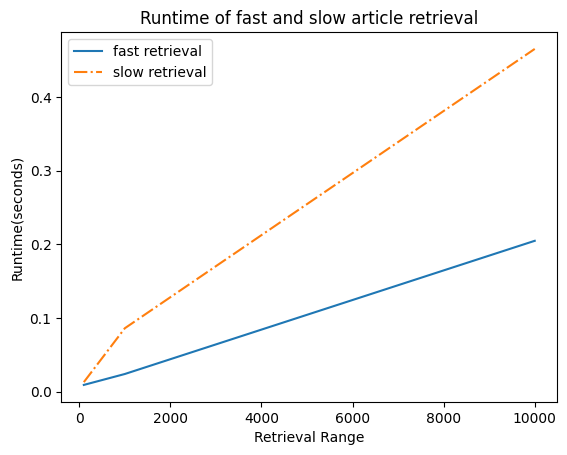

In [ ]:
# plot lines
plt.plot(index, fast_runtimes, label="fast retrieval")
plt.plot(index, slow_runtimes, label="slow retrieval", linestyle="-.")
plt.title("Runtime of fast and slow article retrieval")
plt.xlabel("Retrieval Range")
plt.ylabel("Runtime(seconds)")
plt.legend()
plt.show()

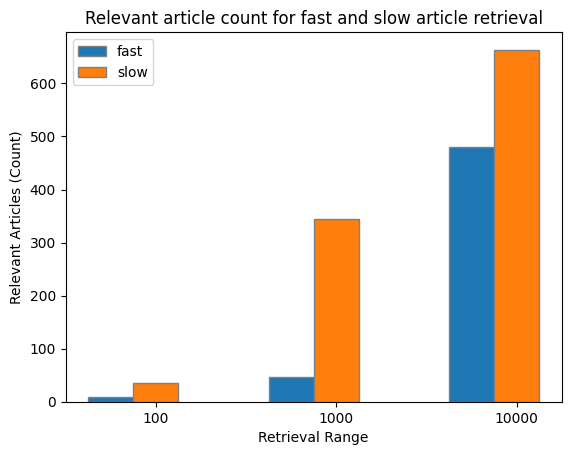

In [ ]:
barWidth = 0.25

br1 = np.arange(len(fast_size))
br2 = [x + barWidth for x in br1]

plt.bar(br1, fast_size,  width = barWidth,
        edgecolor ='grey', label ='fast')
plt.bar(br2, slow_size,  width = barWidth,
        edgecolor ='grey', label ='slow')
plt.xlabel('Retrieval Range')
plt.ylabel('Relevant Articles (Count)')
plt.xticks(br2, ['100', '1000', '10000'])
plt.title("Relevant article count for fast and slow article retrieval")
plt.legend()
plt.show()

### user interface

#### 6.1 Summary
Our user interface outputs three top ranked answers: article number, snippets of text that answers the question and the confidence of the answer.

We had asked two questions in our QA_interface:

1.   which city initially reported COVID-19
2.   what Iran ranks in the world in deaths due to COVID-19

For the first question, our correct answer ranks first, with confidence score of 0.425.

For the second question, our correct answer ranks first, with confidence score of 0.592.

Although our confidence score is not high, we can find out the correct answer in top 3 ranked answers, which means the performance of our search engine is acceptable.

The possible reason is our query parttens match well with the correct answer sentence using tf-idf. 

In [ ]:
class QA_interface(text_matching_utility):
    def __init__(self, entities, dataset, kb):
      super().__init__(entities, dataset, kb)

    def main(self):
        question = None
        print("Please ask a question about COVID.\n")
        print("Please enter 'quit' for quit.\n")
        while True:
          print("Your query is:\n")
          question = str(input())
          if question == 'quit':
              print("\nThank you for your query.")
              break
          top_results = self.text_matching(question, k=5, word_vector="pattern_tfidf")
          plot = self.display_results(top_results)
          

In [ ]:
user_query = QA_interface(entities_100, data_v2_clean[:100], KB)
user_query.main()

Please ask a question about COVID.

Please enter 'quit' for quit.

Your query is:

which city initially reported COVID-19
__________________________________________________

[Article id]: ymebxodh
[Answer]:
 More data on recruitability in patients with COVID-19 are urgently needed to understand the heterogeneity within COVID-19 ARDS.
[Score]: 0.3670539641031466 

[Article id]: qd30tmuy
[Answer]:
 Compared with the control measures taken by other cities, Wuhan have sealed off the city from all outside contact to stop the spread of the COVID-19.
[Score]: 0.32837633200635896 

[Article id]: om1airzt
[Answer]:
 The COVID-19 pandemic is in transition.
[Score]: 0.30899498767644706 

[Article id]: qk0cyee2
[Answer]:
 Third, the distribution of and disparities in the relative vulnerability to severe illness from COVID-19 in the U.S. adult population reported below will be driven by the marginal contributions of individual risk factors displayed in Figure 1 based on the DeCaprio et al.
[Score]:

### 7. References

[1] https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge

[2] https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering

[3] Jurafsky, D & Martin,JH, 2023, 'Speech and Language Processing', https://web.stanford.edu/~jurafsky/slp3/


[4] https://www.holisticseo.digital/python-seo/information-extraction/

[5] https://www.turing.com/kb/guide-on-word-embeddings-in-nlp#glove:-global-vector-for-word-representation

[6] https://nlp.stanford.edu/pubs/glove.pdf

[7] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

[8] https://spacy.io/

[9] https://code.google.com/archive/p/word2vec/

[10] https://radimrehurek.com/gensim/models/keyedvectors.html

[11] https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size

[12] https://github.com/vibhavnirmal/Knowledge-Graph-based-QnA/blob/master/kwQnA/_graph.py